# 笔记

## TSNE

 t-SNE(t-distributed Stochastic Neighbor Embedding)是一个可视化高维数据的工具, ，即t-分布随机邻居嵌入。
 
用法：

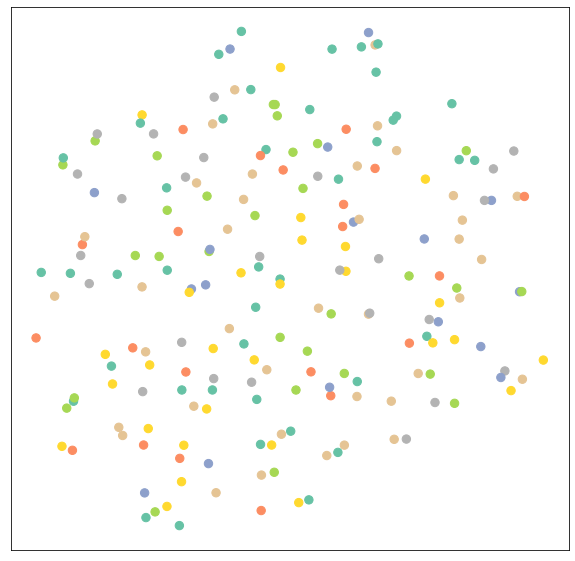

In [65]:
from sklearn.manifold import TSNE
import numpy as np

x=np.random.random([200,7])
y=np.random.randint(0,7,200)
z= TSNE(n_components=2).fit_transform(x)
plt.figure(figsize=(10,10))
plt.xticks([])
plt.yticks([])
plt.scatter(z[:, 0], z[:, 1], s=70,c=y, cmap="Set2")
plt.show()

## pytorch生成随机数

In [4]:
import torch

In [5]:
torch.rand(10)

tensor([0.1251, 0.6789, 0.6847, 0.4866, 0.5905, 0.2387, 0.4547, 0.7604, 0.7394,
        0.8024])

In [6]:
torch.randn(10)>0

tensor([False, False,  True,  True,  True,  True, False,  True,  True,  True])

# 作业

In [62]:
def describe_dataset(dataset):
    print()
    print(f'Dataset: {dataset}:')
    print('======================')
    print(f'Number of graphs: {len(dataset)}')
    print(f'Number of features: {dataset.num_features}')
    print(f'Number of classes: {dataset.num_classes}')

    print()
    print(data)
    print('======================')

    # Gather some statistics about the graph.
    print(f'Number of nodes: {data.num_nodes}')
    print(f'Number of edges: {data.num_edges}')
    print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
    print(f'Number of training nodes: {data.train_mask.sum()}')
    print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
    print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
    print(f'Contains self-loops: {data.contains_self_loops()}')
    print(f'Is undirected: {data.is_undirected()}')

In [66]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE



## Plantoid数据集

In [64]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='dataset/Cora', name='Cora', transform=NormalizeFeatures())

data = dataset[0]  # Get the first graph object.
describe_dataset(dataset)


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(edge_index=[2, 10556], test_mask=[2708], train_mask=[2708], val_mask=[2708], x=[2708, 1433], y=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


In [292]:
from tqdm import tqdm
from time import time
class Model(torch.nn.Module):
    def __init__(self,optimizer=None,criterion=None,**kwargs):
        super(Model, self).__init__()
        self.optimizer=optimizer
        self.criterion=criterion
        
    def _train(self,data,epoch=200):
        def _loss():
            self.train()
            self.optimizer.zero_grad()  # Clear gradients.
            if self.forward.__code__.co_argcount == 2:
                out = self.forward(data.x)  # Perform a single forward pass.
            elif self.forward.__code__.co_argcount == 3:
                out = self.forward(data.x, data.edge_index)
            loss = self.criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
            loss.backward()  # Derive gradients.
            self.optimizer.step()  # Update parameters based on gradients.
            return loss
        t0=time()
        for i in tqdm(range(epoch)):
            loss = _loss()
            if i+1>epoch-10:
                print(f'Epoch: {i+1:03d}, Loss: {loss:.4f}')
        self.time = time()-t0


    def _test(self,data):
        def __test():
            self.eval()
            if self.forward.__code__.co_argcount == 2:
                self.out = self.forward(data.x)
            elif self.forward.__code__.co_argcount == 3:
                self.out = self.forward(data.x, data.edge_index)
            pred = self.out.argmax(dim=1)  # Use the class with highest probability.
            test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
            test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
            return test_acc

        test_acc = __test()
        self.test_acc=test_acc
        print(f'Test Accuracy: {test_acc:.4f}')
        
    def _visualize(self,data):
        def __visualize(out, color):
            z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())
            plt.figure(figsize=(10,10))
            plt.xticks([])
            plt.yticks([])

            plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
            plt.show()

            
        self.eval()
        if self.forward.__code__.co_argcount == 2:
            self.out = self(data.x)
        elif self.forward.__code__.co_argcount == 3:
            self.out = self.forward(data.x, data.edge_index)
        
        __visualize(self.out, color=data.y)

In [248]:
t0=time()
time()-t0

5.14984130859375e-05

### MLP

In [293]:
class MLP(Model):
    def __init__(self, hidden_channels,**kwargs):
        super(MLP, self).__init__(**kwargs)
        torch.manual_seed(12345)
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

In [277]:

model = MLP(hidden_channels=16)
model.criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
model.optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.



In [278]:
model._train(data)

100%|██████████| 200/200 [00:01<00:00, 162.88it/s]

Epoch: 191, Loss: 0.3824
Epoch: 192, Loss: 0.3479
Epoch: 193, Loss: 0.3798
Epoch: 194, Loss: 0.3799
Epoch: 195, Loss: 0.4015
Epoch: 196, Loss: 0.3615
Epoch: 197, Loss: 0.3985
Epoch: 198, Loss: 0.4664
Epoch: 199, Loss: 0.3714
Epoch: 200, Loss: 0.3810


In [261]:
model._test(data)

Test Accuracy: 0.5900


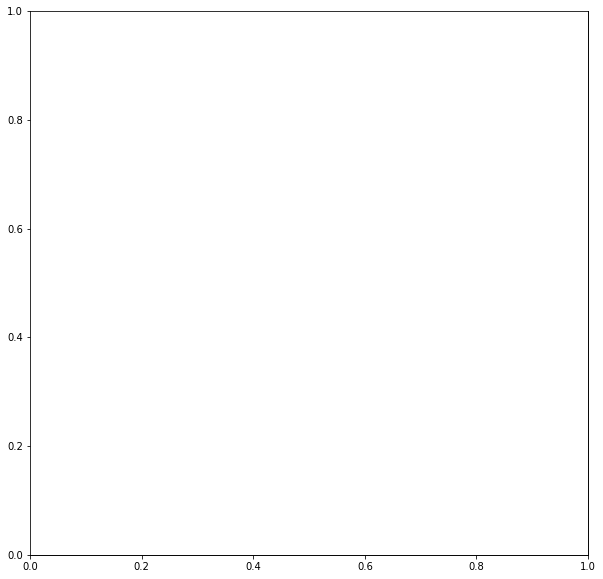

In [279]:
model._visualize(data)

In [274]:
model.fig

<Figure size 432x288 with 0 Axes>

### GCN

In [294]:
from torch_geometric.nn import GCNConv

class GCN(Model):
    def __init__(self, hidden_channels,**kwargs):
        super(GCN, self).__init__(**kwargs)
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x



In [196]:
model = GCN(hidden_channels=16)

print(model)


GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


In [197]:


model = GCN(hidden_channels=16)
model.optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
model.criterion = torch.nn.CrossEntropyLoss()
model._train(data)


100%|██████████| 200/200 [00:03<00:00, 54.91it/s]

Epoch: 191, Loss: 0.3221
Epoch: 192, Loss: 0.3582
Epoch: 193, Loss: 0.3107
Epoch: 194, Loss: 0.3137
Epoch: 195, Loss: 0.3119
Epoch: 196, Loss: 0.2973
Epoch: 197, Loss: 0.3297
Epoch: 198, Loss: 0.3363
Epoch: 199, Loss: 0.3016
Epoch: 200, Loss: 0.3006


In [198]:
model._test(data)

Test Accuracy: 0.8140


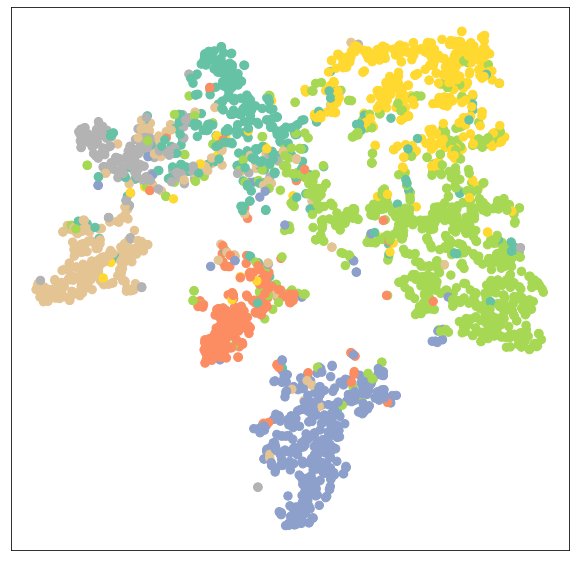

In [199]:
model._visualize(data)

### GAT

In [295]:
import torch
from torch.nn import Linear
import torch.nn.functional as F

from torch_geometric.nn import GATConv

class GAT(Model):
    def __init__(self, hidden_channels):
        super(GAT, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GATConv(dataset.num_features, hidden_channels)
        self.conv2 = GATConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x
    

model = GAT(hidden_channels=16)
print(model) 


GAT(
  (conv1): GATConv(1433, 16, heads=1)
  (conv2): GATConv(16, 7, heads=1)
)


In [201]:
model = GAT(hidden_channels=16)
model.optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
model.criterion = torch.nn.CrossEntropyLoss()

model._train(data)


 96%|█████████▋| 193/200 [00:07<00:00, 25.24it/s]

Epoch: 191, Loss: 0.1851
Epoch: 192, Loss: 0.1981
Epoch: 193, Loss: 0.1897
Epoch: 194, Loss: 0.2172
Epoch: 195, Loss: 0.1980


100%|██████████| 200/200 [00:07<00:00, 26.18it/s]

Epoch: 196, Loss: 0.1634
Epoch: 197, Loss: 0.1879
Epoch: 198, Loss: 0.1658
Epoch: 199, Loss: 0.1657
Epoch: 200, Loss: 0.1926


In [202]:
model._test(data)

Test Accuracy: 0.7380


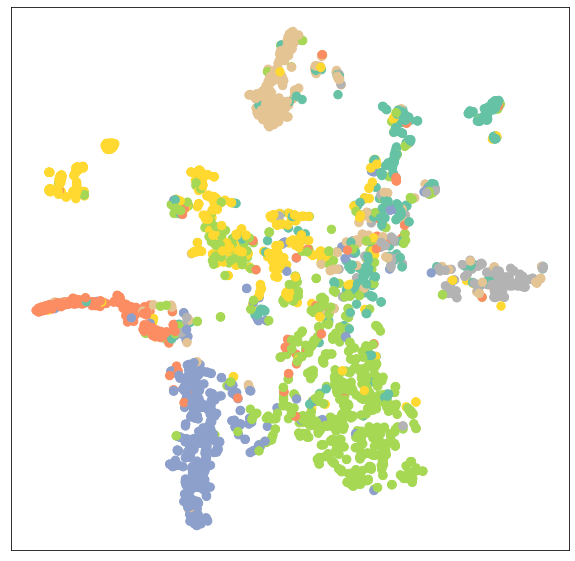

In [203]:
model._visualize(data)

### SAGE

In [296]:
import torch
from torch.nn import Linear
import torch.nn.functional as F

from torch_geometric.nn import SAGEConv

class SAGE(Model):
    def __init__(self, hidden_channels):
        super(SAGE, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = SAGEConv(dataset.num_features, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x
    


In [205]:
model = SAGE(hidden_channels=16)
model.optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
model.criterion = torch.nn.CrossEntropyLoss()

model._train(data)





 96%|█████████▌| 191/200 [00:58<00:02,  3.28it/s]

Epoch: 191, Loss: 0.1471


 96%|█████████▌| 192/200 [00:58<00:02,  3.28it/s]

Epoch: 192, Loss: 0.1233


 96%|█████████▋| 193/200 [00:59<00:02,  3.29it/s]

Epoch: 193, Loss: 0.1169


 97%|█████████▋| 194/200 [00:59<00:01,  3.29it/s]

Epoch: 194, Loss: 0.1391


 98%|█████████▊| 195/200 [00:59<00:01,  3.29it/s]

Epoch: 195, Loss: 0.1326


 98%|█████████▊| 196/200 [00:59<00:01,  3.29it/s]

Epoch: 196, Loss: 0.1518


 98%|█████████▊| 197/200 [01:00<00:00,  3.29it/s]

Epoch: 197, Loss: 0.1351


 99%|█████████▉| 198/200 [01:00<00:00,  3.29it/s]

Epoch: 198, Loss: 0.1606


100%|█████████▉| 199/200 [01:00<00:00,  3.29it/s]

Epoch: 199, Loss: 0.1352


100%|██████████| 200/200 [01:01<00:00,  3.27it/s]

Epoch: 200, Loss: 0.1286


In [206]:
model._test(data)

Test Accuracy: 0.7970


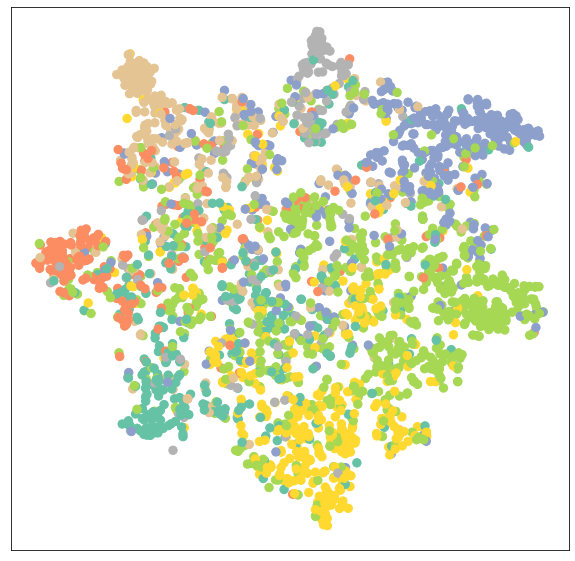

In [212]:
model._visualize(data)

### GraphConv 

In [297]:
import torch
from torch.nn import Linear
import torch.nn.functional as F

from torch_geometric.nn import GraphConv

class GraphC(Model):
    def __init__(self, hidden_channels):
        super(GraphC, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GraphConv(dataset.num_features, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x
    

In [ ]:
model = GraphC(hidden_channels=16)

model.optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
model.criterion = torch.nn.CrossEntropyLoss()

model._train(data)



In [214]:
model._test(data)

Test Accuracy: 0.7740


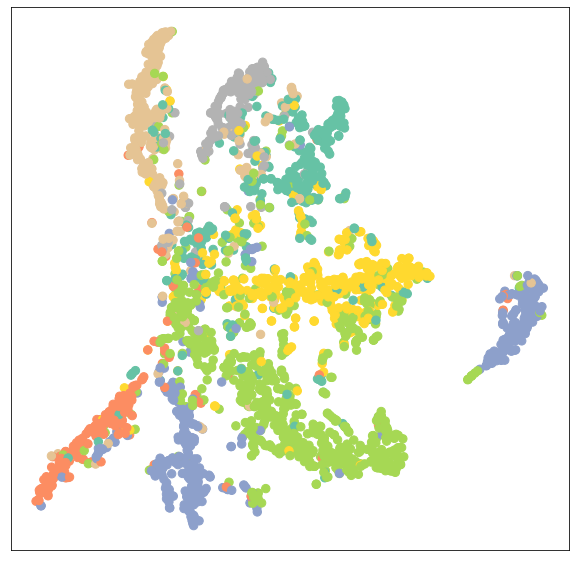

In [215]:
model._visualize(data)

### GatedGraphConv

In [298]:

import torch
from torch.nn import Linear
import torch.nn.functional as F

from torch_geometric.nn import GatedGraphConv



class GatedGraph(Model):
    def __init__(self, hidden_channels):
        super(GatedGraph, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GraphConv(dataset.num_features, hidden_channels,aggr='add')
        self.conv2 = GatedGraphConv(hidden_channels, dataset.num_classes ,aggr='add'  )

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x


In [243]:
model = GatedGraph(hidden_channels=16)

model.optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
model.criterion = torch.nn.CrossEntropyLoss()

model._train(data)

  4%|▍         | 8/200 [00:03<01:12,  2.66it/s]


KeyboardInterrupt: 

In [220]:
model._test(data)

Test Accuracy: 0.3250


### ChebConv

In [299]:



import torch
from torch.nn import Linear
import torch.nn.functional as F

from torch_geometric.nn import ChebConv



class ChebC(Model):
    def __init__(self, hidden_channels):
        super(ChebC, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = ChebConv(dataset.num_features, hidden_channels,10,aggr='add')
        self.conv2 = ChebConv(hidden_channels, dataset.num_classes ,10,aggr='add'  )

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x



In [ ]:

model = ChebC(hidden_channels=16)

model.optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
model.criterion = torch.nn.CrossEntropyLoss()

model._train(data)

In [227]:
model._test(data)

Test Accuracy: 0.7270


In [232]:
MLP(hidden_channels=16)

MLP(
  (lin1): Linear(in_features=1433, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=7, bias=True)
)

In [300]:
models = [
    MLP(hidden_channels=16),
    GCN(hidden_channels=16),
    GAT(hidden_channels=16),
    SAGE(hidden_channels=16),
    GraphC(hidden_channels=16),
    GatedGraph(hidden_channels=16),
    ChebC(hidden_channels=16) 
]

In [301]:
for model in models:
    
    model.optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    model.criterion = torch.nn.CrossEntropyLoss()

In [302]:
for model in models:
    model._train(data)
    model._test(data)

  3%|▎         | 6/200 [00:00<00:03, 55.19it/s]

Epoch: 191, Loss: 0.4487
Epoch: 192, Loss: 0.4667
Epoch: 193, Loss: 0.4482
Epoch: 194, Loss: 0.4823
Epoch: 195, Loss: 0.4488
Epoch: 196, Loss: 0.4096
Epoch: 197, Loss: 0.4484
Epoch: 198, Loss: 0.3876
Epoch: 199, Loss: 0.4330
Epoch: 200, Loss: 0.4033
Test Accuracy: 0.5920


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 191, Loss: 0.3210
Epoch: 192, Loss: 0.3167
Epoch: 193, Loss: 0.3041
Epoch: 194, Loss: 0.3620
Epoch: 195, Loss: 0.2998
Epoch: 196, Loss: 0.2863
Epoch: 197, Loss: 0.3119
Epoch: 198, Loss: 0.3017
Epoch: 199, Loss: 0.3080
Epoch: 200, Loss: 0.3086
Test Accuracy: 0.8060


 98%|█████████▊| 195/200 [00:07<00:00, 26.76it/s]

Epoch: 191, Loss: 0.1912
Epoch: 192, Loss: 0.1714
Epoch: 193, Loss: 0.1935
Epoch: 194, Loss: 0.2241
Epoch: 195, Loss: 0.2059
Epoch: 196, Loss: 0.2204


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 197, Loss: 0.2161
Epoch: 198, Loss: 0.1740
Epoch: 199, Loss: 0.1852
Epoch: 200, Loss: 0.1895
Test Accuracy: 0.7540


 96%|█████████▌| 191/200 [00:58<00:02,  3.27it/s]

Epoch: 191, Loss: 0.1386


 96%|█████████▌| 192/200 [00:58<00:02,  3.26it/s]

Epoch: 192, Loss: 0.1427


 96%|█████████▋| 193/200 [00:59<00:02,  3.26it/s]

Epoch: 193, Loss: 0.1319


 97%|█████████▋| 194/200 [00:59<00:01,  3.26it/s]

Epoch: 194, Loss: 0.1134


 98%|█████████▊| 195/200 [00:59<00:01,  3.23it/s]

Epoch: 195, Loss: 0.1515


 98%|█████████▊| 196/200 [01:00<00:01,  3.24it/s]

Epoch: 196, Loss: 0.1496


 98%|█████████▊| 197/200 [01:00<00:00,  3.25it/s]

Epoch: 197, Loss: 0.1198


 99%|█████████▉| 198/200 [01:00<00:00,  3.25it/s]

Epoch: 198, Loss: 0.1405


100%|█████████▉| 199/200 [01:01<00:00,  3.25it/s]

Epoch: 199, Loss: 0.1447


100%|██████████| 200/200 [01:01<00:00,  3.26it/s]

Epoch: 200, Loss: 0.1161



  0%|          | 0/200 [00:00<?, ?it/s]

Test Accuracy: 0.7820


 96%|█████████▌| 191/200 [00:58<00:02,  3.28it/s]

Epoch: 191, Loss: 0.0794


 96%|█████████▌| 192/200 [00:58<00:02,  3.23it/s]

Epoch: 192, Loss: 0.0583


 96%|█████████▋| 193/200 [00:59<00:02,  3.24it/s]

Epoch: 193, Loss: 0.0563


 97%|█████████▋| 194/200 [00:59<00:01,  3.24it/s]

Epoch: 194, Loss: 0.0500


 98%|█████████▊| 195/200 [00:59<00:01,  3.25it/s]

Epoch: 195, Loss: 0.0502


 98%|█████████▊| 196/200 [01:00<00:01,  3.26it/s]

Epoch: 196, Loss: 0.0539


 98%|█████████▊| 197/200 [01:00<00:00,  3.27it/s]

Epoch: 197, Loss: 0.0601


 99%|█████████▉| 198/200 [01:00<00:00,  3.27it/s]

Epoch: 198, Loss: 0.0752


100%|█████████▉| 199/200 [01:00<00:00,  3.28it/s]

Epoch: 199, Loss: 0.0724


100%|██████████| 200/200 [01:01<00:00,  3.26it/s]

Epoch: 200, Loss: 0.0529



  0%|          | 0/200 [00:00<?, ?it/s]

Test Accuracy: 0.7740


 96%|█████████▌| 191/200 [01:04<00:03,  2.96it/s]

Epoch: 191, Loss: 1.6630


 96%|█████████▌| 192/200 [01:05<00:02,  2.96it/s]

Epoch: 192, Loss: 1.6699


 96%|█████████▋| 193/200 [01:05<00:02,  2.96it/s]

Epoch: 193, Loss: 1.6632


 97%|█████████▋| 194/200 [01:05<00:02,  2.95it/s]

Epoch: 194, Loss: 1.6627


 98%|█████████▊| 195/200 [01:06<00:01,  2.95it/s]

Epoch: 195, Loss: 1.6859


 98%|█████████▊| 196/200 [01:06<00:01,  2.95it/s]

Epoch: 196, Loss: 1.6675


 98%|█████████▊| 197/200 [01:06<00:01,  2.94it/s]

Epoch: 197, Loss: 1.6625


 99%|█████████▉| 198/200 [01:07<00:00,  2.94it/s]

Epoch: 198, Loss: 1.6625


100%|█████████▉| 199/200 [01:07<00:00,  2.94it/s]

Epoch: 199, Loss: 1.6607


100%|██████████| 200/200 [01:07<00:00,  2.95it/s]

Epoch: 200, Loss: 1.6636



  0%|          | 0/200 [00:00<?, ?it/s]

Test Accuracy: 0.3090


 96%|█████████▌| 191/200 [14:32<00:40,  4.55s/it]

Epoch: 191, Loss: 0.0362


 96%|█████████▌| 192/200 [14:37<00:35,  4.49s/it]

Epoch: 192, Loss: 0.0375


 96%|█████████▋| 193/200 [14:41<00:31,  4.47s/it]

Epoch: 193, Loss: 0.0441


 97%|█████████▋| 194/200 [14:46<00:27,  4.51s/it]

Epoch: 194, Loss: 0.0475


 98%|█████████▊| 195/200 [14:50<00:22,  4.48s/it]

Epoch: 195, Loss: 0.0357


 98%|█████████▊| 196/200 [14:55<00:18,  4.54s/it]

Epoch: 196, Loss: 0.0446


 98%|█████████▊| 197/200 [15:00<00:13,  4.56s/it]

Epoch: 197, Loss: 0.0464


 99%|█████████▉| 198/200 [15:04<00:09,  4.57s/it]

Epoch: 198, Loss: 0.0315


100%|█████████▉| 199/200 [15:09<00:04,  4.55s/it]

Epoch: 199, Loss: 0.0400


100%|██████████| 200/200 [15:13<00:00,  4.57s/it]

Epoch: 200, Loss: 0.0368


Test Accuracy: 0.7270


In [303]:
import pickle

In [306]:
fo=open('models_platoid.pkl','wb')
pickle.dump(models,fo)
fo.close()

In [309]:
pickle.load(open('models_platoid.pkl','rb'))

[MLP(
   (lin1): Linear(in_features=1433, out_features=16, bias=True)
   (lin2): Linear(in_features=16, out_features=7, bias=True)
   (criterion): CrossEntropyLoss()
 ),
 GCN(
   (conv1): GCNConv(1433, 16)
   (conv2): GCNConv(16, 7)
   (criterion): CrossEntropyLoss()
 ),
 GAT(
   (conv1): GATConv(1433, 16, heads=1)
   (conv2): GATConv(16, 7, heads=1)
   (criterion): CrossEntropyLoss()
 ),
 SAGE(
   (conv1): SAGEConv(1433, 16)
   (conv2): SAGEConv(16, 7)
   (criterion): CrossEntropyLoss()
 ),
 GraphC(
   (conv1): GraphConv(1433, 16)
   (conv2): GraphConv(16, 7)
   (criterion): CrossEntropyLoss()
 ),
 GatedGraph(
   (conv1): GraphConv(1433, 16)
   (conv2): GatedGraphConv(16, num_layers=7)
   (criterion): CrossEntropyLoss()
 ),
 ChebC(
   (conv1): ChebConv(1433, 16, K=10, normalization=sym)
   (conv2): ChebConv(16, 7, K=10, normalization=sym)
   (criterion): CrossEntropyLoss()
 )]

## Coauthor data set

In [314]:
from torch_geometric.datasets import Coauthor
from torch_geometric.transforms import NormalizeFeatures

dataset = Coauthor(root='dataset/Physics', name='Physics', transform=NormalizeFeatures())

data = dataset[0]  
data.train_mask= torch.randn(data.num_nodes)>0
data.test_mask = (data.train_mask == False)
describe_dataset(dataset)


Dataset: CoauthorPhysics():
Number of graphs: 1
Number of features: 8415
Number of classes: 5

Data(edge_index=[2, 495924], test_mask=[34493], train_mask=[34493], x=[34493, 8415], y=[34493])
Number of nodes: 34493
Number of edges: 495924
Average node degree: 14.38
Number of training nodes: 17189
Training node label rate: 0.50
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


In [83]:



import torch
from torch.nn import Linear
import torch.nn.functional as F

from torch_geometric.nn import GATConv



class GAT(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GAT, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GATConv(dataset.num_features, hidden_channels)
        self.conv2 = GATConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x
    



model = GAT(hidden_channels=16)

model.optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
model.criterion = torch.nn.CrossEntropyLoss()

model._train(data)

Epoch: 020, Loss: 1.1721
Epoch: 040, Loss: 0.8646
Epoch: 060, Loss: 0.7094
Epoch: 080, Loss: 0.5941
Epoch: 100, Loss: 0.4671
Epoch: 120, Loss: 0.3841
Epoch: 140, Loss: 0.3386
Epoch: 160, Loss: 0.3076
Epoch: 180, Loss: 0.2889
Epoch: 196, Loss: 0.2722
Epoch: 197, Loss: 0.2704
Epoch: 198, Loss: 0.2736
Epoch: 199, Loss: 0.2761
Epoch: 200, Loss: 0.2699


In [91]:
def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.9417


In [315]:
models = [
    MLP(hidden_channels=16),
    GCN(hidden_channels=16),
    GAT(hidden_channels=16),
    SAGE(hidden_channels=16),
    GraphC(hidden_channels=16),
    GatedGraph(hidden_channels=16),
    ChebC(hidden_channels=16) 
]

In [316]:
for model in models:
    
    model.optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    model.criterion = torch.nn.CrossEntropyLoss()

In [317]:
for model in models:
    model._train(data)
    model._test(data)

 96%|█████████▌| 191/200 [01:16<00:03,  2.50it/s]

Epoch: 191, Loss: 0.4969


 96%|█████████▌| 192/200 [01:16<00:03,  2.50it/s]

Epoch: 192, Loss: 0.4979


 96%|█████████▋| 193/200 [01:17<00:02,  2.50it/s]

Epoch: 193, Loss: 0.4977


 97%|█████████▋| 194/200 [01:17<00:02,  2.50it/s]

Epoch: 194, Loss: 0.4952


 98%|█████████▊| 195/200 [01:17<00:01,  2.50it/s]

Epoch: 195, Loss: 0.4950


 98%|█████████▊| 196/200 [01:18<00:01,  2.50it/s]

Epoch: 196, Loss: 0.4929


 98%|█████████▊| 197/200 [01:18<00:01,  2.50it/s]

Epoch: 197, Loss: 0.4927


 99%|█████████▉| 198/200 [01:19<00:00,  2.50it/s]

Epoch: 198, Loss: 0.4951


100%|█████████▉| 199/200 [01:19<00:00,  2.51it/s]

Epoch: 199, Loss: 0.4939


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 200, Loss: 0.4912
Test Accuracy: 0.9255


 96%|█████████▌| 191/200 [03:06<00:08,  1.02it/s]

Epoch: 191, Loss: 0.3104


 96%|█████████▌| 192/200 [03:07<00:07,  1.02it/s]

Epoch: 192, Loss: 0.3116


 96%|█████████▋| 193/200 [03:08<00:06,  1.02it/s]

Epoch: 193, Loss: 0.3098


 97%|█████████▋| 194/200 [03:09<00:05,  1.02it/s]

Epoch: 194, Loss: 0.3087


 98%|█████████▊| 195/200 [03:10<00:04,  1.02it/s]

Epoch: 195, Loss: 0.3104


 98%|█████████▊| 196/200 [03:11<00:03,  1.02it/s]

Epoch: 196, Loss: 0.3064


 98%|█████████▊| 197/200 [03:12<00:02,  1.02it/s]

Epoch: 197, Loss: 0.3069


 99%|█████████▉| 198/200 [03:13<00:01,  1.02it/s]

Epoch: 198, Loss: 0.3062


100%|█████████▉| 199/200 [03:14<00:00,  1.02it/s]

Epoch: 199, Loss: 0.3053


100%|██████████| 200/200 [03:15<00:00,  1.02it/s]

Epoch: 200, Loss: 0.3064



  0%|          | 0/200 [00:00<?, ?it/s]

Test Accuracy: 0.9445


 96%|█████████▌| 191/200 [04:49<00:13,  1.51s/it]

Epoch: 191, Loss: 0.2774


 96%|█████████▌| 192/200 [04:50<00:12,  1.51s/it]

Epoch: 192, Loss: 0.2770


 96%|█████████▋| 193/200 [04:52<00:10,  1.51s/it]

Epoch: 193, Loss: 0.2723


 97%|█████████▋| 194/200 [04:53<00:09,  1.51s/it]

Epoch: 194, Loss: 0.2770


 98%|█████████▊| 195/200 [04:55<00:07,  1.51s/it]

Epoch: 195, Loss: 0.2731


 98%|█████████▊| 196/200 [04:56<00:06,  1.52s/it]

Epoch: 196, Loss: 0.2744


 98%|█████████▊| 197/200 [04:58<00:04,  1.52s/it]

Epoch: 197, Loss: 0.2779


 99%|█████████▉| 198/200 [04:59<00:03,  1.52s/it]

Epoch: 198, Loss: 0.2717


100%|█████████▉| 199/200 [05:01<00:01,  1.52s/it]

Epoch: 199, Loss: 0.2745


100%|██████████| 200/200 [05:02<00:00,  1.51s/it]

Epoch: 200, Loss: 0.2672



  0%|          | 0/200 [00:00<?, ?it/s]

Test Accuracy: 0.9453


  0%|          | 0/200 [00:00<?, ?it/s]


RuntimeError: [enforce fail at CPUAllocator.cpp:67] . DefaultCPUAllocator: can't allocate memory: you tried to allocate 16692801840 bytes. Error code 12 (Cannot allocate memory)

In [ ]:
fo=open('models_pcoauther.pkl','wb')
pickle.dump(models,fo)
fo.close()